In [1]:
# Tick History PCAP, SQL request API :
import maystreet_data

# Refinitiv Data Platform API :
import refinitiv.data as rd

import pandas as pd 
import numpy as np 
import datetime as dt
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
### Date used for Historical Data Simulation 
date = "2023-06-28"
date2 = "2023-06-29"

In [3]:
rd.open_session(config_name='../pwd/session.json')

<refinitiv.data.session.Definition object at 0x7f1d5143c3d0 {name='rdp'}>

In [4]:
ric = "'BMWG.DE'"             
anse = rd.content.search.Definition(      
    view = rd.content.search.Views.EQUITY_DERIVATIVE_QUOTES,
    filter = "AssetState eq 'AC' and \
                startswith(UnderlyingQuoteRIC, " + ric + ") and \
                endswith(UnderlyingQuoteRIC," + ric + ") and \
                RCSAssetClass eq 'OPT' and IsChain eq false and \
                ExpiryDate ge 2023-12-15", # + dt.datetime.today().strftime('%Y-%m-%d'), 
    select = "DocumentTitle, RIC, ExpiryDate, CallPutOption, StrikePrice",  
    navigators="ExchangeName",               
    top = 10000                 
).get_data()
df_options = anse.data.df
df_options = df_options[df_options['DocumentTitle'].str.contains('Eurex')]
# df_options = df_options[df_options['DocumentTitle'].str.contains('Monthly')]
df_options = df_options[df_options['CallPutOption'] == 'Call']
df_options = df_options[df_options['StrikePrice'] == 100]
df_options = df_options[df_options['ExpiryDate'] == '2023-12-15']
df_options

,DocumentTitle,RIC,ExpiryDate,CallPutOption,StrikePrice
27,Eurex Monthly BMW Equity Option 100 Call Dec 2...,BMWG1000dL3.EX,2023-12-15,Call,100.0
28,"Eurex BMW AG Equity Option 100 Call Dec 2023 ,...",BMWE1000L3.EX,2023-12-15,Call,100.0


In [5]:
df_option =  rd.get_history(
    universe=['BMWE1000L3.EX'],
    interval="tick",
    # fields=["underlying_timestamp", "BID", "ASK"],
    start=date,
    end=date2)
df_option = df_option.reset_index()
df_option = df_option.rename(columns = {
                    'BID' : 'opt_bid',
                    'ASK' : 'opt_ask',
                    'Timestamp' : 'opt_timestamp'
                    })
df_option = df_option[['opt_bid', 'opt_ask', 'opt_timestamp']]
df_option['opt'] = 'BMWE1000L3.EX' #'BMWG1000dL3.EX' # ''
df_option = df_option.dropna(subset=['opt_bid', 'opt_ask'], how='all')
df_option = df_option.fillna(method = 'ffill')
df_option['opt_avg'] = (df_option['opt_bid'] + df_option['opt_ask']) / 2
df_option.loc[df_option['opt_avg'].isna(), 'opt_avg'] = df_option['opt_ask']
df_option.loc[df_option['opt_avg'].isna(), 'opt_avg'] = df_option['opt_bid']
df_option = df_option[~df_option.duplicated()]
df_option = df_option.reset_index(drop = True)
df_option.head()

BMWE1000L3.EX,opt_bid,opt_ask,opt_timestamp,opt,opt_avg
0,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225
1,13.05,13.35,2023-06-28 07:01:34.704,BMWE1000L3.EX,13.2
2,13.0,13.35,2023-06-28 07:01:38.928,BMWE1000L3.EX,13.175
3,13.0,13.3,2023-06-28 07:01:39.844,BMWE1000L3.EX,13.15
4,13.0,13.35,2023-06-28 07:01:39.915,BMWE1000L3.EX,13.175


In [6]:
df_BMW =  rd.get_history(
    universe=['BMWG.DE'],
    fields=['BID', 'ASK'],
    interval="tick",
    start=date,
    end=date2)
df_BMW = df_BMW.reset_index()
df_BMW = df_BMW.rename(columns = {
                    'BID' : 'underlying_bid',
                    'ASK' : 'underlying_ask',
                    'Timestamp' : 'underlying_timestamp'
                    })
df_BMW = df_BMW[['underlying_bid', 'underlying_ask', 'underlying_timestamp']]
df_BMW['underlying'] = 'BMW'
df_BMW = df_BMW.dropna(subset=['underlying_bid', 'underlying_ask'], how='all')
df_BMW = df_BMW.reset_index(drop=True)
df_BMW = df_BMW.ffill()
df_BMW['underlying_avg'] = (df_BMW['underlying_bid'] + df_BMW['underlying_ask']) / 2
df_BMW = df_BMW[~df_BMW.duplicated()]
df_BMW = df_BMW.reset_index(drop = True)
df_BMW.head()

BMWG.DE,underlying_bid,underlying_ask,underlying_timestamp,underlying,underlying_avg
0,108.52,108.56,2023-06-28 07:00:13.064,BMW,108.54
1,108.56,108.58,2023-06-28 07:00:13.064,BMW,108.57
2,108.54,108.56,2023-06-28 07:00:13.064,BMW,108.55
3,108.54,108.58,2023-06-28 07:00:13.064,BMW,108.56
4,108.5,108.56,2023-06-28 07:00:13.064,BMW,108.53


### Call OPtion Price - Black Schole Model
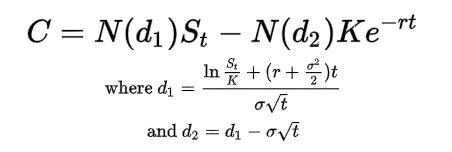

C = call option price <br>
N = CDF of the normal distribution<br>
St= spot price of an asset<br>
K = strike price<br>
r = risk-free interest rate<br>
t = time to maturity<br>
σ = volatility of the asset<br>

In [7]:
### Fixing some parameters
r = 0.045
N = norm.cdf
N_prime = norm.pdf
sigma = np.sqrt(252) * 0.015304757885578736
K = 100
exp_date = dt.datetime(2023, 12, 15, 0, 0) #'2023-12-15'
today_date = dt.datetime(2023, 6, 28, 0, 0)
T = ((exp_date - today_date).days) / 365

In [8]:
def black_scholes_call(S, K, T, r, sigma):
    '''
    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    '''
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * N(d1) -  N(d2)* K * np.exp(-r * T)
    return call

df_BMW['opt_estimated_price'] = df_BMW.underlying_avg.apply(black_scholes_call, args = (K, T, r, sigma))
df_BMW.head()


BMWG.DE,underlying_bid,underlying_ask,underlying_timestamp,underlying,underlying_avg,opt_estimated_price
0,108.52,108.56,2023-06-28 07:00:13.064,BMW,108.54,13.396625
1,108.56,108.58,2023-06-28 07:00:13.064,BMW,108.57,13.419407
2,108.54,108.56,2023-06-28 07:00:13.064,BMW,108.55,13.404217
3,108.54,108.58,2023-06-28 07:00:13.064,BMW,108.56,13.411811
4,108.5,108.56,2023-06-28 07:00:13.064,BMW,108.53,13.389034


In [9]:
### Option used for the Simulation
option_name = 'BMW SI 20231215 PS AM C 100.00 0'

### Using PCAP Normalized Data to download one option price with timestamp
def query_apu():
    return f"""
    SELECT
        dt, product, f,  firstexchangetimestamp, bidprice_1, askprice_1
    FROM
        "prod_lake"."p_mst_data_lake"."mt_aggregated_price_update"
    WHERE
        f='emdi_eurex_t7'
        AND dt= '{date}'
        AND product = '{option_name}'
    ORDER BY
        firstexchangetimestamp
"""
records_iter = maystreet_data.query(maystreet_data.DataSource.DATA_LAKE, query_apu())
df_option_pcap = pd.DataFrame(records_iter)
df_option_pcap['firstexchangetimestamp'] = pd.to_datetime(df_option_pcap.firstexchangetimestamp)
df_option_pcap = df_option_pcap.rename(columns = {
                    'bidprice_1' : 'opt_bid_pcap',
                    'askprice_1' : 'opt_ask_pcap',
                    'firstexchangetimestamp' : 'opt_timestamp_pcap',
                    'product' : 'opt_pcap'
                    })
df_option_pcap = df_option_pcap.drop(['f', 'dt'], axis = 1)
df_option_pcap['opt_avg_pcap'] = (df_option_pcap['opt_bid_pcap'] + df_option_pcap['opt_ask_pcap']) / 2
df_option_pcap = df_option_pcap[~df_option_pcap.duplicated()]
df_option_pcap = df_option_pcap.reset_index(drop = True)
df_option_pcap.head()

,opt_pcap,opt_timestamp_pcap,opt_bid_pcap,opt_ask_pcap,opt_avg_pcap
0,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.150
1,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:03:02.354608566,13.05,13.35,13.200
2,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:06:11.073035513,13.40,13.70,13.550
3,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:06:57.446147325,13.30,13.65,13.475
4,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:06:58.928088158,13.30,13.65,13.475


In [10]:
### Merge Option price df, and underlying price df
df_m_opt = pd.merge_asof(df_BMW, df_option, left_on= "underlying_timestamp", right_on="opt_timestamp" , direction = 'nearest')
df_m_opt_pcap = pd.merge_asof(df_BMW, df_option_pcap, left_on= "underlying_timestamp", right_on="opt_timestamp_pcap" , direction = 'nearest')
df = pd.merge_asof(df_BMW, df_option, left_on= "underlying_timestamp", right_on="opt_timestamp" , direction = 'nearest')
df = pd.merge_asof(df, df_option_pcap, left_on= "underlying_timestamp", right_on="opt_timestamp_pcap" , direction = 'nearest')
df = df[~df.duplicated()]
df = df.reset_index(drop = True)
df.head()

,underlying_bid,underlying_ask,underlying_timestamp,underlying,underlying_avg,opt_estimated_price,opt_bid,opt_ask,opt_timestamp,opt,opt_avg,opt_pcap,opt_timestamp_pcap,opt_bid_pcap,opt_ask_pcap,opt_avg_pcap
0,108.52,108.56,2023-06-28 07:00:13.064,BMW,108.54,13.396625,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
1,108.56,108.58,2023-06-28 07:00:13.064,BMW,108.57,13.419407,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
2,108.54,108.56,2023-06-28 07:00:13.064,BMW,108.55,13.404217,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
3,108.54,108.58,2023-06-28 07:00:13.064,BMW,108.56,13.411811,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
4,108.5,108.56,2023-06-28 07:00:13.064,BMW,108.53,13.389034,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15


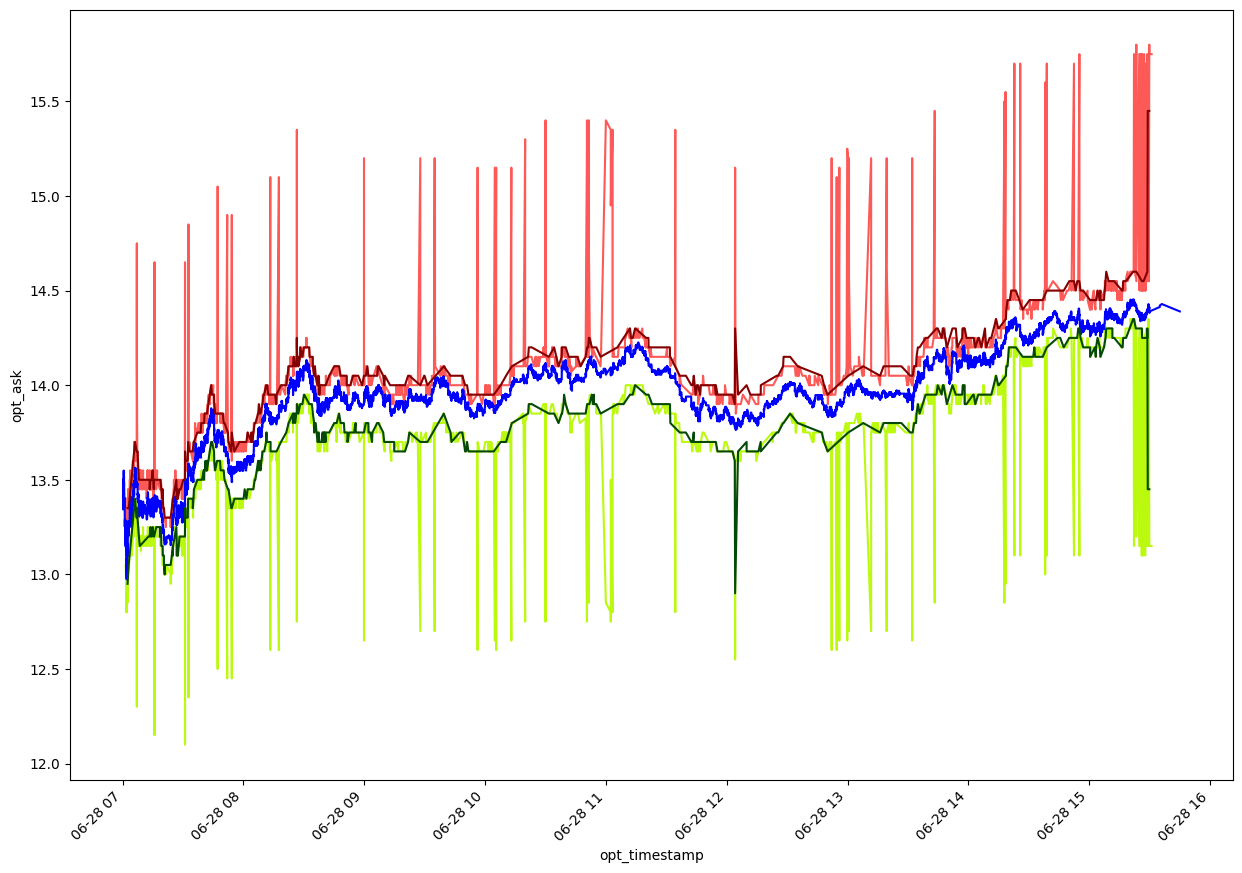

In [11]:
fix, ax = plt.subplots(figsize=(15,10))
sns.lineplot(df_option, x = 'opt_timestamp', y = 'opt_ask', color = sns.xkcd_rgb['grapefruit'])
sns.lineplot(df_option, x = 'opt_timestamp', y = 'opt_bid', color = sns.xkcd_rgb['yellowgreen'])
sns.lineplot(df_BMW, x = 'underlying_timestamp', y = 'opt_estimated_price', color = 'blue')
sns.lineplot(df_option_pcap, x = 'opt_timestamp_pcap', y = 'opt_ask_pcap', color = sns.xkcd_rgb['dark red'])
sns.lineplot(df_option_pcap, x = 'opt_timestamp_pcap', y = 'opt_bid_pcap', color = sns.xkcd_rgb['darkgreen'])
plt.xticks(rotation=45, ha='right')
plt.show()

## Implied Volatility Calculation using Newton-Raphson Method

In [12]:
def vega(S, K, T, r, sigma):
    '''
    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / sigma * np.sqrt(T)
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega


def implied_volatility_call(C, S, K, T, r, sigma, tol=0.0001, max_iterations=100):
    '''
    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''
    for i in range(max_iterations):
        diff = black_scholes_call(S, K, T, r, sigma) - C
        if abs(diff) < tol:
            #print(f'On {i}th iteration, difference is equal to {diff}')
            break
        sigma = sigma - diff / vega(S, K, T, r, sigma)
    return sigma
    
df_m_opt['implied_vol'] = df_m_opt.apply(lambda x: implied_volatility_call(x.opt_avg, x.underlying_avg,K, T, r, sigma), axis=1)
df_m_opt_pcap['implied_vol_pcap'] = df_m_opt_pcap.apply(lambda x: implied_volatility_call(x.opt_avg_pcap, x.underlying_avg,K, T, r, sigma), axis=1)
df.head()

,underlying_bid,underlying_ask,underlying_timestamp,underlying,underlying_avg,opt_estimated_price,opt_bid,opt_ask,opt_timestamp,opt,opt_avg,opt_pcap,opt_timestamp_pcap,opt_bid_pcap,opt_ask_pcap,opt_avg_pcap
0,108.52,108.56,2023-06-28 07:00:13.064,BMW,108.54,13.396625,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
1,108.56,108.58,2023-06-28 07:00:13.064,BMW,108.57,13.419407,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
2,108.54,108.56,2023-06-28 07:00:13.064,BMW,108.55,13.404217,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
3,108.54,108.58,2023-06-28 07:00:13.064,BMW,108.56,13.411811,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15
4,108.5,108.56,2023-06-28 07:00:13.064,BMW,108.53,13.389034,13.05,13.4,2023-06-28 07:01:34.304,BMWE1000L3.EX,13.225,BMW SI 20231215 PS AM C 100.00 0,2023-06-28 07:02:28.782369494,12.95,13.35,13.15


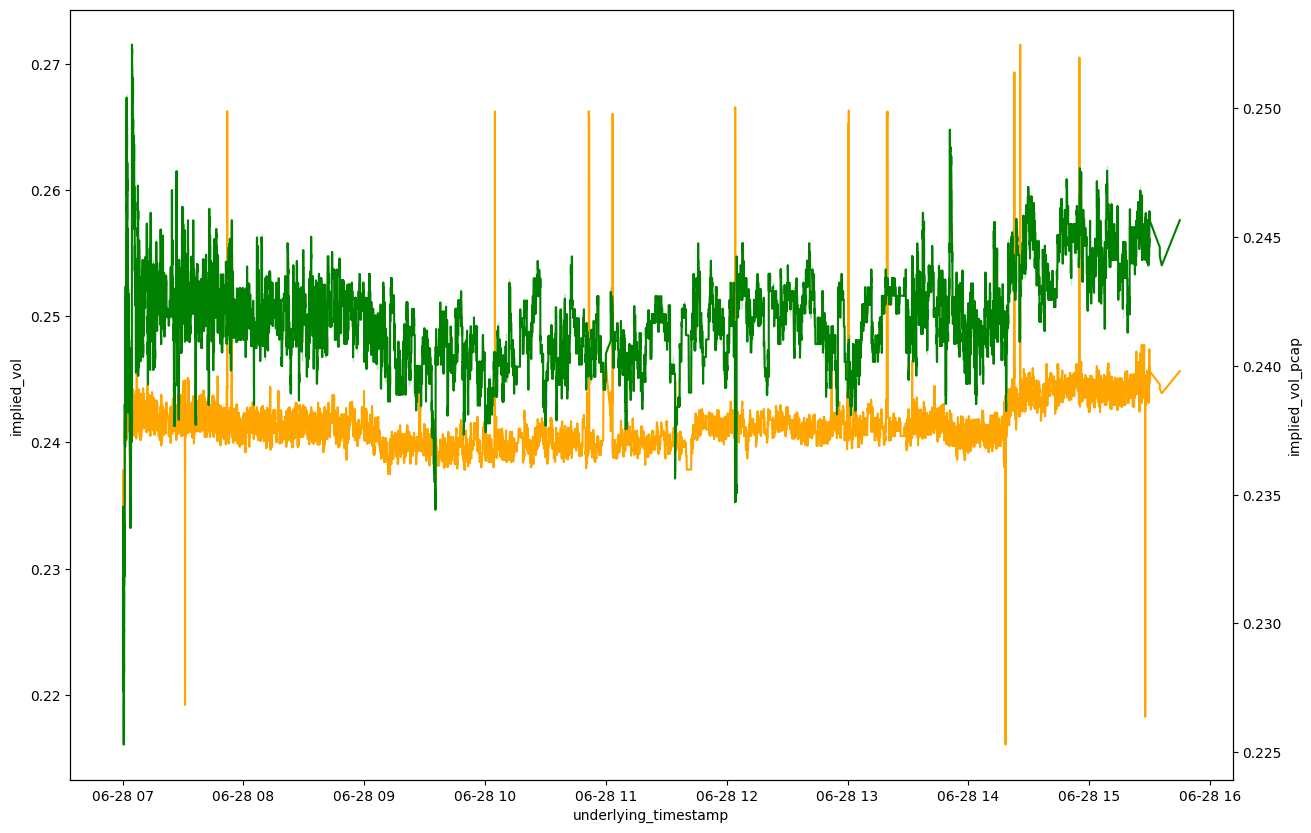

In [13]:
# df['lr']= np.log(df.underlying_avg.pct_change()+1)
fix, ax1 = plt.subplots(figsize=(15,10))
sns.lineplot(df_m_opt, x = 'underlying_timestamp', y = 'implied_vol', color = 'orange', ax = ax1)
ax2 = ax1.twinx()
sns.lineplot(df_m_opt_pcap, x = 'underlying_timestamp', y = 'implied_vol_pcap', color = 'green', ax = ax2)
plt.show()

## Volatility Surface

In [14]:
from mpl_toolkits import mplot3d
from datetime import datetime
from itertools import chain
from tqdm import tqdm

In [15]:
### Using PCAP Normalized Data to download one option price with timestamp
def query_apu():
    return f"""
    SELECT
        dt, product, f,  firstexchangetimestamp, bidprice_1, askprice_1
    FROM
        "prod_lake"."p_mst_data_lake"."mt_aggregated_price_update"
    WHERE
        f='emdi_eurex_t7'
        AND dt > '{date}'
        AND product LIKE '%BMW%'
    ORDER BY
        firstexchangetimestamp
"""
records_iter = maystreet_data.query(maystreet_data.DataSource.DATA_LAKE, query_apu())
df_options = pd.DataFrame(records_iter)
df_options['firstexchangetimestamp'] = pd.to_datetime(df_options.firstexchangetimestamp)
df_options = df_options.rename(columns = {
                    'product' : 'opt',
                    'bidprice_1' : 'opt_bid',
                    'askprice_1' : 'opt_ask',
                    'firstexchangetimestamp' : 'opt_timestamp'
                    })
df_options = df_options.drop(['f', 'dt'], axis = 1)
df_options['opt_avg'] = (df_options['opt_bid'] + df_options['opt_ask']) / 2

df_options.loc[df_options['opt_avg'].isna(), 'opt_avg'] = df_options['opt_ask']
df_options.loc[df_options['opt_avg'].isna(), 'opt_avg'] = df_options['opt_bid']
df_options[['p', 'si', 'opt_exp', 'ps', 'am', 'opt_side', 'opt_strike', 'O']]= df_options.opt.str.split(' ', expand = True)
df_options['opt_exp'] = pd.to_datetime(df_options['opt_exp'])
df_options = df_options.drop(['p', 'si', 'ps', 'am', 'O'], axis = 1)
df_options['opt_strike'] = df_options['opt_strike'].astype('float')
df_options.head()

,opt,opt_timestamp,opt_bid,opt_ask,opt_avg,opt_exp,opt_side,opt_strike
0,BMW SI 20230915 PS AM C 116.00 0,2023-06-29 07:00:45.117911021,NaN,3.00,3.00,2023-09-15,C,116.0
1,BMWE SI 20230721 PS EU P 89.00 0,2023-06-29 07:00:45.158058225,0.1,NaN,0.10,2023-07-21,P,89.0
2,BMW SI 20230721 PS AM P 96.00 0,2023-06-29 07:00:58.614603731,NaN,0.29,0.29,2023-07-21,P,96.0
3,BMW SI 20241220 PS AM P 92.00 0,2023-06-29 07:00:58.614959734,NaN,5.65,5.65,2024-12-20,P,92.0
4,BMW SI 20240621 PS AM P 96.00 0,2023-06-29 07:00:58.614959734,NaN,5.05,5.05,2024-06-21,P,96.0


In [16]:
### Keep CAll options only, calculate Maturity
df_options = df_options[df_options['opt_side'] == 'C']
df_options['maturity'] = ((df_options['opt_exp'] -  today_date)/ np.timedelta64(1, 'D')) / 365

### Merge Option price df, and underlying price df
df_vol= pd.merge_asof(df_options, df_BMW, left_on= "opt_timestamp", right_on="underlying_timestamp")

In [17]:
### Calculating underlying_implied_vol
tqdm.pandas()
df_vol['underlying_implied_vol'] = df_vol.progress_apply(lambda x: implied_volatility_call(x.opt_avg, x.underlying_avg,  x.opt_strike, x.maturity, r, sigma), axis=1)
df_vol.head()
df_vol.to_csv('df_vol.csv', index = False)
# df_vol = pd.read_csv('df_vol.csv')

  0%|          | 1/917514 [00:04<1144:49:24,  4.49s/it]/tmp/ipykernel_9738/1077289697.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = sigma - diff / vega(S, K, T, r, sigma)
/tmp/ipykernel_9738/3215447466.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
  0%|          | 12/917514 [00:04<70:50:48,  3.60it/s] /tmp/ipykernel_9738/3215447466.py:10: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
  0%|          | 2130/917514 [00:15<58:59, 258.59it/s]  /tmp/ipykernel_9738/1077289697.py:31: RuntimeWarning: overflow encountered in double_scalars
  sigma = sigma - diff / vega(S, K, T, r, sigma)
 15%|█▌        | 138557/917514 [13:13<1:56:53, 111.07it/s]

In [ ]:
fig = plt.figure(figsize=(10,10))
axs = plt.axes(projection="3d")
axs.plot_trisurf(df_vol.opt_strike, df_vol.maturity, df_vol.underlying_implied_vol, cmap=cm.jet)
axs.view_init(30, 65)
axs.set_xlim(50, 200)
axs.set_ylim(0.0054, 2)
axs.set_zlim(0, 1.01)
plt.xlabel("opt_strike")
plt.ylabel("maturity")
plt.show()